<a href="https://colab.research.google.com/github/WillPG4/MachineLearning/blob/main/Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem formalization
The objective is to build a regression model that can predict:
- **CO₂ emissions** (`Value_co2_emissions_kt_by_country`)
- **Renewable energy share** (`Renewable energy share in the total final energy consumption (%)`)

The features include electricity access, fossil fuel use, renewable capacity, GDP, and energy intensity.
We assume non-linear relationships between energy consumption and emissions.


In [24]:
# --- General setup and reproducibility ---
from sklearn import set_config
import numpy as np, random
SEED = 42
import numpy as np, random
np.random.seed(SEED)
random.seed(SEED)

# Versions (optional, for traceability)
import sys, pandas as pd, sklearn
print(f"Python {sys.version.split()[0]} | pandas {pd.__version__} | scikit-learn {sklearn.__version__}")

# Sanity check: ensure all expected columns are present
required = {
    'Entity','Year','Latitude','Longitude',
    'Primary energy consumption per capita (kWh/person)',
    'gdp_per_capita','Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
    'Electricity from renewables (TWh)',
    'Access to clean fuels for cooking','Electricity from fossil fuels (TWh)',
    'Low-carbon electricity (% electricity)','Electricity from nuclear (TWh)',
    'Renewable-electricity-generating-capacity-per-capita',
    'Value_co2_emissions_kt_by_country',
    'Renewable energy share in the total final energy consumption (%)'
}
missing = [c for c in required if c not in df.columns]
assert not missing, f"Missing columns: {missing}"


Python 3.12.12 | pandas 2.2.2 | scikit-learn 1.6.1


In [2]:
# ================================
# Machine Learning : Country access to electricity
# ================================

# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_columns", 200)


In [3]:
# ================================
# 1) Lecture du fichier (Colab)
# ================================
from google.colab import files
uploaded = files.upload()                     # sélectionne ton .csv
fname = list(uploaded.keys())[0]

# détection automatique du séparateur (',' ';' '\t' etc.)
df = pd.read_csv(fname, sep=None, engine="python")
df.head()


Saving Excel .csv to Excel .csv


,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,65.957440,302.59482,1.64,760.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,84.745766,236.89185,1.74,730.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,81.159424,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,652230.0,33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,67.021280,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,62.921350,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,652230.0,33.93911,67.709953


In [25]:
# ================================
# 2) Dataframe cleaning
# ================================

# A. Vérification du volume d'années disponibles
years_per_country = df.groupby("Entity")["Year"].count().sort_values()
print(years_per_country)

# B. Suppression des pays avec trop peu d'années (critère objectif)
# Exemple : garder uniquement les pays avec > 10 années de données
valid_countries = years_per_country[years_per_country > 10].index

df = df[df["Entity"].isin(valid_countries)]

print("\nShape after country filtering:", df.shape)

# C. Réinitialisation de l'index
df = df.reset_index(drop=True)


Entity
Montenegro             14
Serbia                 14
Algeria                21
Afghanistan            21
Antigua and Barbuda    21
                       ..
Uzbekistan             21
Vanuatu                21
Yemen                  21
Zambia                 21
Zimbabwe               21
Name: Year, Length: 174, dtype: int64

Shape after country filtering: (3640, 21)


In [5]:
# Liste des colonnes à imputer (conforme au notebook)
nan_cols = [
    'Access to electricity (% of population)',
    'Electricity from fossil fuels (TWh)',
    'Electricity from renewables (TWh)',
    'Low-carbon electricity (% electricity)',
    'Electricity from nuclear (TWh)',
    'Access to clean fuels for cooking',
    'Renewable energy share in the total final energy consumption (%)',
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
    'gdp_per_capita',
    'gdp_growth',
    'Value_co2_emissions_kt_by_country',
    'Renewable-electricity-generating-capacity-per-capita'
]
nan_cols = [c for c in nan_cols if c in df.columns]

# Imputation en 2 temps
df = df.sort_values(['Entity', 'Year'])

# Mobile average for each country
for col in nan_cols:
    df[col] = df.groupby('Entity')[col].transform(
        lambda x: x.fillna(x.rolling(window=3, min_periods=1).mean())
    )

# Global mean of countries for each variable by year
for col in nan_cols:
    df[col] = df.groupby('Year')[col].transform(lambda x: x.fillna(df[col].mean()))

# Vérif NaN restants
df_nan = df.isna().sum() / len(df) * 100
df_nan.sort_values()


,0
Entity,0.000000
Year,0.000000
Access to electricity (% of population),0.000000
Access to clean fuels for cooking,0.000000
Renewable-electricity-generating-capacity-per-capita,0.000000
Renewable energy share in the total final energy consumption (%),0.000000
Electricity from fossil fuels (TWh),0.000000
Electricity from nuclear (TWh),0.000000
Energy intensity level of primary energy (MJ/$2017 PPP GDP),0.000000
Electricity from renewables (TWh),0.000000


In [6]:
# C. Inconsistencies

# Zero
zero_count = (df == 0).sum()
zero_freq  = (df == 0).mean() * 100
zero_freq.sort_values()

# Negative
numeric_cols = df.select_dtypes(include=['number']).columns
(df[numeric_cols] < 0).sum().sort_values()

# Percentages (bornes 0..100)
percent_cols = ["Access to electricity (% of population)",
                "Access to clean fuels for cooking",
                "Low-carbon electricity (% electricity)",
                "Renewable energy share in the total final energy consumption (%)"]
percent_cols = [c for c in percent_cols if c in df.columns]

print((df[percent_cols] > 100).sum())
(df[percent_cols] < 0).sum()

# Correction simple si >100 (cas isolés)
df.loc[df['Low-carbon electricity (% electricity)'] > 100, 'Low-carbon electricity (% electricity)'] = 100
(df[percent_cols] > 100).sum()


Access to electricity (% of population)                             0
Access to clean fuels for cooking                                   0
Low-carbon electricity (% electricity)                              1
Renewable energy share in the total final energy consumption (%)    0
dtype: int64


,0
Access to electricity (% of population),0
Access to clean fuels for cooking,0
Low-carbon electricity (% electricity),0
Renewable energy share in the total final energy consumption (%),0


In [7]:
# Latitude and longitude (si présentes)
if {'Latitude','Longitude'}.issubset(df.columns):
    lat = df[(df['Latitude'] < -90) | (df['Latitude'] > 90)]
    long = df[(df['Longitude'] < -180) | (df['Longitude'] > 180)]
    print('out of range lat : ', len(lat))
    print('out of range long : ', len(long))


out of range lat :  0
out of range long :  0


Land Area(Km2)                                                 105
Primary energy consumption per capita (kWh/person)             103
gdp_per_capita                                                  86
Energy intensity level of primary energy (MJ/$2017 PPP GDP)     75
Electricity from renewables (TWh)                               73
Electricity from nuclear (TWh)                                  56
gdp_growth                                                      51
Electricity from fossil fuels (TWh)                             47
Value_co2_emissions_kt_by_country                               45
Renewable-electricity-generating-capacity-per-capita            45
dtype: int64


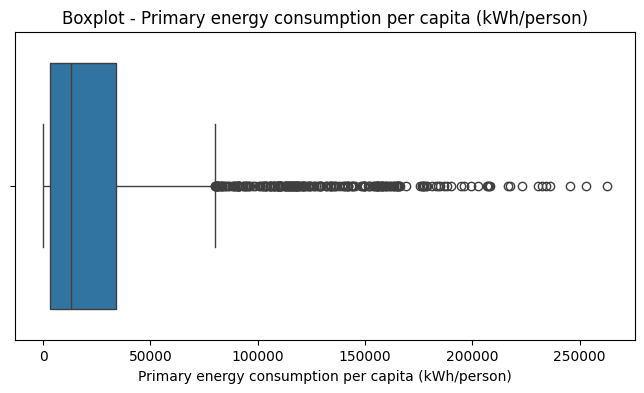

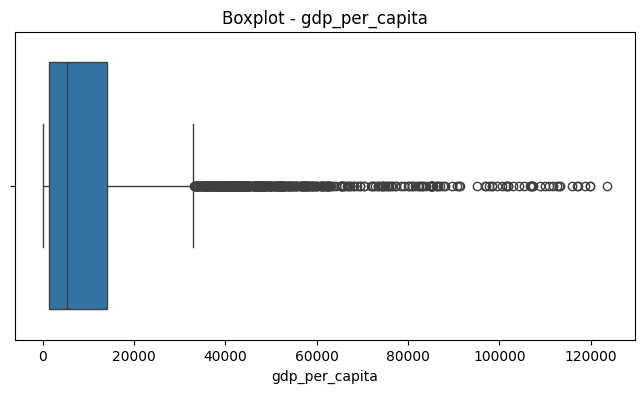

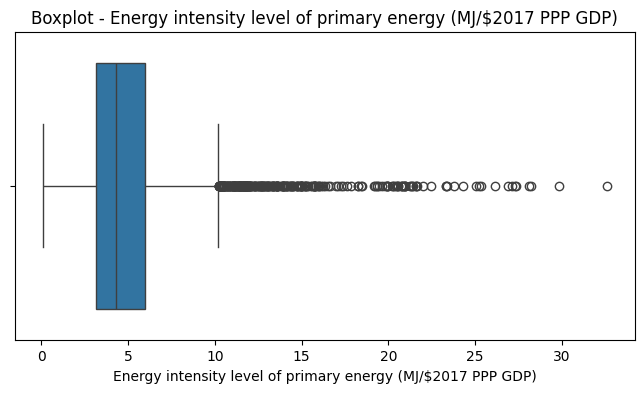

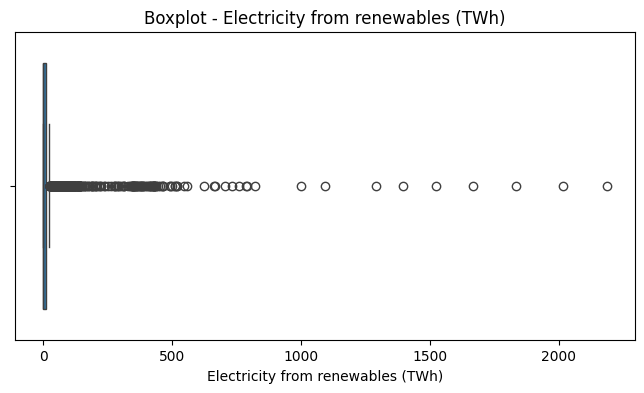

/tmp/ipython-input-3488967378.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


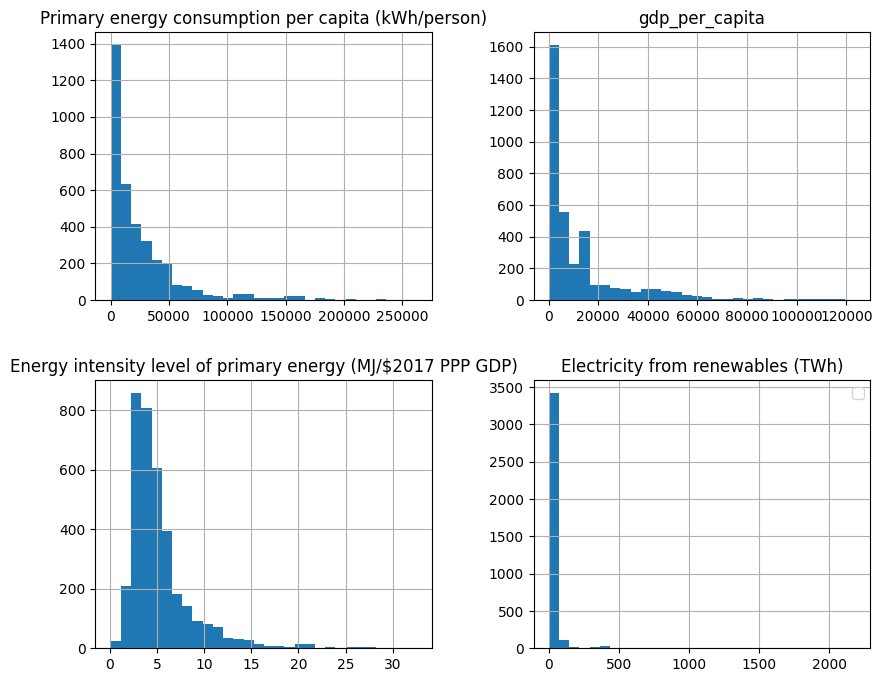


=== Pays avec valeurs extrêmes (Outliers détectés) ===

--- Primary energy consumption per capita (kWh/person) ---
     Entity  Primary energy consumption per capita (kWh/person)
2708  Qatar                                          262585.70 
2707  Qatar                                          253062.60 
2718  Qatar                                          245271.83 
2716  Qatar                                          236185.81 
2717  Qatar                                          234538.38 
2715  Qatar                                          232316.58 
2709  Qatar                                          230796.00 
2719  Qatar                                          223248.58 
2706  Qatar                                          217673.23 
2714  Qatar                                          216384.27 

--- gdp_per_capita ---
          Entity  gdp_per_capita
1968  Luxembourg     123514.1967
1967  Luxembourg     119966.0349
1962  Luxembourg     119932.2437
1965  Luxembourg     118

In [8]:
# D. Outliers

# Stats descriptives
df.describe().T.sort_values("max", ascending=False)

# Comptage de z-scores > 3 (valeurs extrêmes statistiques)
z_scores = df.select_dtypes('number').apply(stats.zscore)
outlier_counts = (abs(z_scores) > 3).sum()
print(outlier_counts.sort_values(ascending=False).head(10))

# Visualisations simples
cols_to_check = [
    'Primary energy consumption per capita (kWh/person)',
    'gdp_per_capita',
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
    'Electricity from renewables (TWh)'
]
cols_to_check = [c for c in cols_to_check if c in df.columns]

# Boxplots individuels
for col in cols_to_check:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot - {col}')
    plt.show()

# Histogrammes
df[cols_to_check].hist(figsize=(10,8), bins=30)
plt.legend()
plt.show()

# -----------------------------
# Nouvelle partie : identification des pays extrêmes
# -----------------------------
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Détection automatique du nom de colonne "Entity"
entity_col = [c for c in df.columns if 'Entity' in c or 'entity' in c][0]

print("\n=== Pays avec valeurs extrêmes (Outliers détectés) ===")
for col in cols_to_check:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR

    outliers = df[df[col] > upper][[entity_col, col]]
    print(f'\n--- {col} ---')
    if not outliers.empty:
        print(outliers.sort_values(by=col, ascending=False).head(10))
    else:
        print("Aucun outlier détecté pour cette variable.")


In [9]:
# ================================
# E. Scaling (version sans erreur)
# ================================

from sklearn.preprocessing import StandardScaler

# 1. Sélectionne uniquement les colonnes numériques
num_cols = df.select_dtypes('number').columns.drop(['Year'], errors='ignore')

# 2. Normalisation (centrer-réduire)
scaler = StandardScaler()
scaled = scaler.fit_transform(df[num_cols])
df_scaled = pd.DataFrame(scaled, index=df.index, columns=num_cols)

# 3. Colonnes d’identification disponibles (pas toutes obligatoires)
id_cols = [c for c in ['Entity', 'Year', 'Latitude', 'Longitude', 'Land Area(Km2)', 'Density (P/Km2)'] if c in df.columns]

# 4. Reconcaténation
df_scaled = pd.concat([df[id_cols], df_scaled], axis=1)

# 5. Vérification
print("Shape après scaling :", df_scaled.shape)
df_scaled.head()



Shape après scaling : (3640, 23)


,Entity,Year,Latitude,Longitude,Land Area(Km2),Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,33.93911,67.709953,652230.0,-2.576842,-1.503123,-0.493852,-0.316661,0.417501,-0.202580,-0.187781,-0.227534,0.852201,-0.732944,-1.042955,-0.212689,NaN,8.172887e-17,-9.593467e-17,0.011998,0.648055,0.796952
1,Afghanistan,2001,33.93911,67.709953,652230.0,-2.494997,-1.476845,-0.495561,-0.316293,0.438017,-0.202781,-0.187781,-0.225711,1.403071,-0.734833,-1.014236,-0.212728,NaN,8.172887e-17,-9.593467e-17,0.011998,0.648055,0.796952
2,Afghanistan,2002,33.93911,67.709953,652230.0,-2.317584,-1.450567,-0.497413,-0.303499,0.176686,-0.202666,-0.187781,-0.225136,1.297920,-0.735581,-1.111882,-0.212330,NaN,8.172887e-17,-6.920719e-01,0.011998,0.648055,0.796952
3,Afghanistan,2003,33.93911,67.709953,652230.0,-2.140346,-1.416406,-0.499217,-0.229750,0.137335,-0.202148,-0.187781,-0.224464,0.883393,-0.735032,-1.111882,-0.212078,NaN,9.915783e-01,-6.914782e-01,0.011998,0.648055,0.796952
4,Afghanistan,2004,33.93911,67.709953,652230.0,-1.963203,-1.379617,-0.500831,NaN,0.392276,-0.202091,-0.187781,-0.225136,0.763183,-0.735772,-1.169321,-0.212330,NaN,-3.736379e-01,-6.903865e-01,0.011998,0.648055,0.796952



=== Correlations with target: Value_co2_emissions_kt_by_country ===
Value_co2_emissions_kt_by_country                     1.000000
Electricity from fossil fuels (TWh)                   0.988606
Electricity from renewables (TWh)                     0.857006
Land Area(Km2)                                        0.647993
Electricity from nuclear (TWh)                        0.602036
Access to electricity (% of population)               0.122417
Financial flows to developing countries (US $)        0.121892
Latitude                                              0.112864
gdp_per_capita                                        0.094129
Primary energy consumption per capita (kWh/person)    0.093213
Name: Value_co2_emissions_kt_by_country, dtype: float64

=== Most negative correlations with Value_co2_emissions_kt_by_country ===
Renewable energy share in the total final energy consumption (%)   -0.127609
Renewables (% equivalent primary energy)                           -0.069952
Low-carbon elect

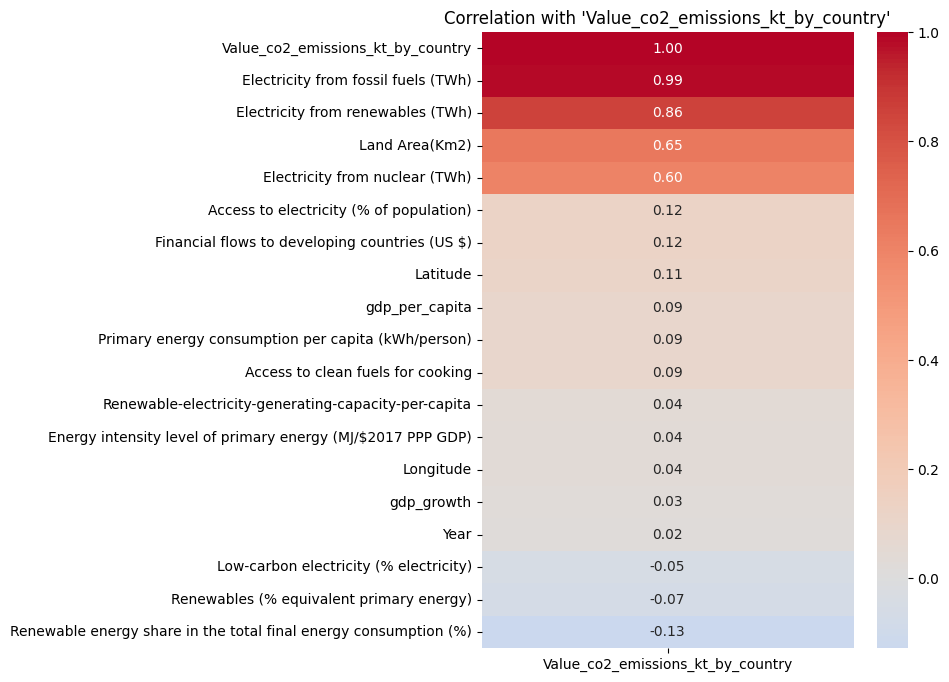


=== Correlations with target: Renewable energy share in the total final energy consumption (%) ===
Renewable energy share in the total final energy consumption (%)    1.000000
Renewables (% equivalent primary energy)                            0.770736
Low-carbon electricity (% electricity)                              0.459232
Energy intensity level of primary energy (MJ/$2017 PPP GDP)         0.248682
gdp_growth                                                          0.083728
Renewable-electricity-generating-capacity-per-capita                0.047784
Longitude                                                           0.017505
Financial flows to developing countries (US $)                     -0.006072
Year                                                               -0.030546
Land Area(Km2)                                                     -0.045189
Name: Renewable energy share in the total final energy consumption (%), dtype: float64

=== Most negative correlations with Renewa

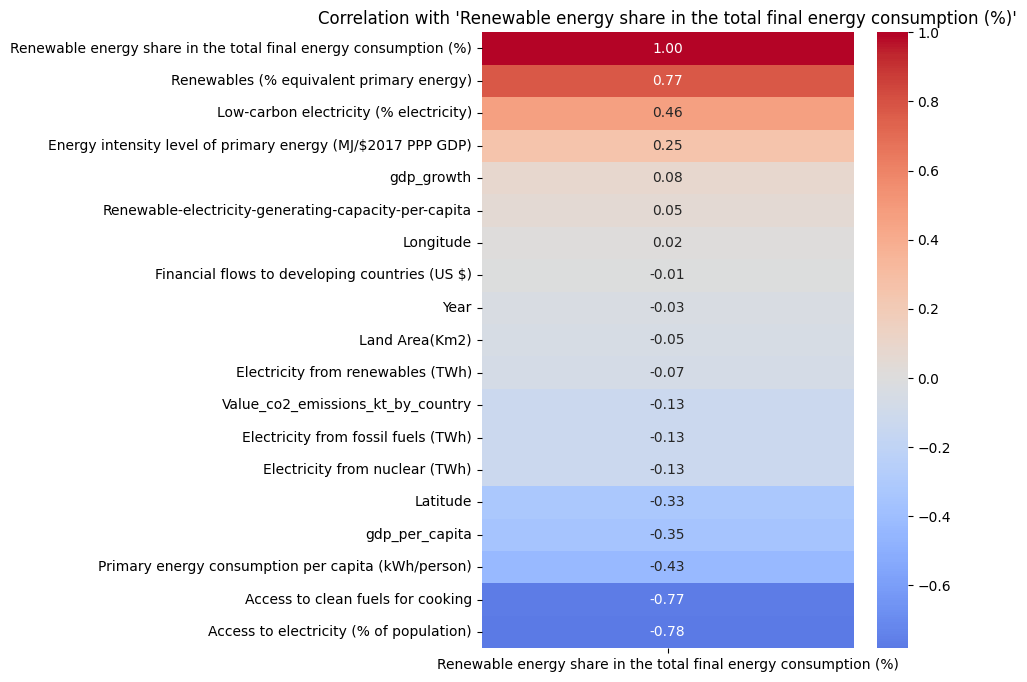

In [18]:
# ============================
# F1. Correlation analysis (exploratoire)
# ============================

import seaborn as sns
import matplotlib.pyplot as plt

targets = [
    'Value_co2_emissions_kt_by_country',
    'Renewable energy share in the total final energy consumption (%)'
]

corr = df.corr(numeric_only=True)

for target in targets:
    if target not in corr.columns:
        print(f"\n[WARNING] Target '{target}' not found in df.columns")
        continue

    print(f"\n=== Correlations with target: {target} ===")
    print(corr[target].sort_values(ascending=False).head(10))

    print(f"\n=== Most negative correlations with {target} ===")
    print(corr[target].sort_values(ascending=True).head(10))

    plt.figure(figsize=(6, 8))
    sns.heatmap(
        corr[[target]].sort_values(by=target, ascending=False),
        cmap='coolwarm', center=0, annot=True, fmt=".2f"
    )
    plt.title(f"Correlation with '{target}'")
    plt.show()


In [20]:
# ============================
# F1bis. Feature selection for modelling
# ============================

# Colonnes numériques
num_cols = df.select_dtypes('number').columns

# mêmes targets
targets = [
    'Value_co2_emissions_kt_by_country',
    'Renewable energy share in the total final energy consumption (%)'
]

# Features = toutes les colonnes numériques sauf les deux targets
features = [c for c in num_cols if c not in targets]

print("Features sélectionnées :", features)
print("Targets :", targets)

# Matrice explicative
X = df[features]


Features sélectionnées : ['Year', 'Access to electricity (% of population)', 'Access to clean fuels for cooking', 'Renewable-electricity-generating-capacity-per-capita', 'Financial flows to developing countries (US $)', 'Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)', 'Electricity from renewables (TWh)', 'Low-carbon electricity (% electricity)', 'Primary energy consumption per capita (kWh/person)', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 'Renewables (% equivalent primary energy)', 'gdp_growth', 'gdp_per_capita', 'Land Area(Km2)', 'Latitude', 'Longitude']
Targets : ['Value_co2_emissions_kt_by_country', 'Renewable energy share in the total final energy consumption (%)']


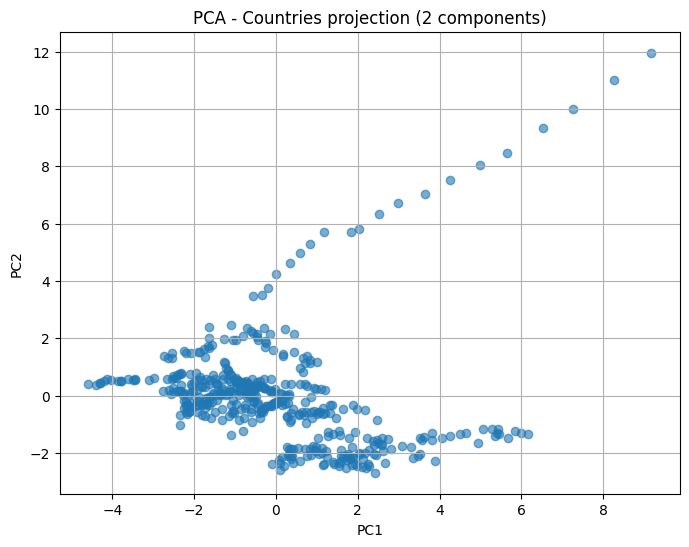

Explained variance:
PC1: 25.37%
PC2: 21.49%
Total (PC1+PC2): 46.86%


In [21]:
# ============================
# F2. ACP (Analyse en Composantes Principales)
# ============================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# On part des features définies en F1
X_pca_input = df[features].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca_input)

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Entity': df.loc[X_pca_input.index, 'Entity'].values
})

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6)
plt.title("PCA - Countries projection (2 components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

print("Explained variance:")
print(f"PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"Total (PC1+PC2): {pca.explained_variance_ratio_.sum()*100:.2f}%")


Variables utilisées pour le clustering :
['Access to electricity (% of population)', 'Access to clean fuels for cooking', 'Primary energy consumption per capita (kWh/person)', 'Electricity from fossil fuels (TWh)', 'Electricity from renewables (TWh)', 'Low-carbon electricity (% electricity)', 'Renewable-electricity-generating-capacity-per-capita', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 'gdp_per_capita', 'gdp_growth']

Variance expliquée par les 2 composantes PCA (clustering) :
[0.2918755  0.17716033]


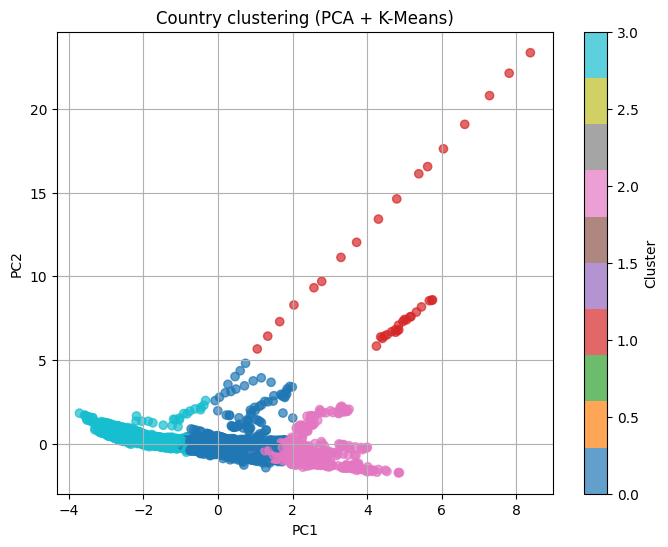


=== Exemples de pays par cluster ===

Cluster 0 (exemples) :
['Afghanistan' 'Albania' 'Algeria' 'Antigua and Barbuda' 'Argentina'
 'Armenia' 'Aruba' 'Australia' 'Austria' 'Azerbaijan']

Cluster 1 (exemples) :
['China' 'United States']

Cluster 2 (exemples) :
['Aruba' 'Australia' 'Austria' 'Bahrain' 'Belgium' 'Bermuda' 'Canada'
 'Cayman Islands' 'Denmark' 'Finland']

Cluster 3 (exemples) :
['Afghanistan' 'Angola' 'Bangladesh' 'Benin' 'Bhutan' 'Botswana'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon']


In [15]:
# ============================
# F3. Country clustering (K-Means)
# ============================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1) Choix des variables pour regrouper les pays
cluster_cols = [
    'Access to electricity (% of population)',
    'Access to clean fuels for cooking',
    'Primary energy consumption per capita (kWh/person)',
    'Electricity from fossil fuels (TWh)',
    'Electricity from renewables (TWh)',
    'Low-carbon electricity (% electricity)',
    'Renewable-electricity-generating-capacity-per-capita',
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
    'gdp_per_capita',
    'gdp_growth'
]

# On garde seulement les colonnes qui existent vraiment dans le df
cluster_cols = [c for c in cluster_cols if c in df.columns]

print("Variables utilisées pour le clustering :")
print(cluster_cols)

# On crée un sous-dataframe avec Entity + ces variables, et on enlève les lignes avec NaN
df_cluster = df[['Entity'] + cluster_cols].dropna().copy()

# 2) Standardisation
X_cluster = df_cluster[cluster_cols]
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# 3) PCA pour visualiser les clusters en 2D
pca_cluster = PCA(n_components=2)
X_cluster_pca = pca_cluster.fit_transform(X_cluster_scaled)

print("\nVariance expliquée par les 2 composantes PCA (clustering) :")
print(pca_cluster.explained_variance_ratio_)

# 4) K-Means (on commence avec 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster_scaled)

df_cluster['Cluster'] = clusters

# 5) Visualisation des clusters dans le plan PCA
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_cluster_pca[:, 0],
    X_cluster_pca[:, 1],
    c=clusters,
    cmap='tab10',
    alpha=0.7
)
plt.title("Country clustering (PCA + K-Means)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()

# 6) Exemple : liste des pays par cluster
print("\n=== Exemples de pays par cluster ===")
for k in sorted(df_cluster['Cluster'].unique()):
    countries = df_cluster[df_cluster['Cluster'] == k]['Entity'].unique()[:10]
    print(f"\nCluster {k} (exemples) :")
    print(countries)

# Si tu veux la liste complète des pays par cluster :
# df_cluster.groupby('Cluster')['Entity'].unique()


We applied PCA (2 components) combined with K-Means (k=4) to group countries based on their energy indicators and economic variables.
After standardizing the data, PCA reduces the dataset while preserving ~47% of total variance, making the clusters easier to visualize.

The K-Means algorithm produces 4 clear groups of countries, each representing a different energy–economic profile:

Cluster 0 – Emerging economies:
Moderate energy use and rising emissions.
Examples: Algeria, Argentina, Albania.

Cluster 1 – Global superpowers:
Extremely high energy consumption and CO₂ emissions; outliers in the dataset.
Examples: China, United States.

Cluster 2 – Developed economies:
High GDP per capita, more efficient energy use, stronger renewable share.
Examples: Austria, Belgium, Canada, Denmark.

Cluster 3 – Low-income countries:
Very low energy consumption and emissions.
Examples: Bangladesh, Benin, Cambodia.

This confirms distinct country groups that can support forecasting and comparative analysis.

Features used: ['Year', 'Access to electricity (% of population)', 'Access to clean fuels for cooking', 'Renewable-electricity-generating-capacity-per-capita', 'Financial flows to developing countries (US $)', 'Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)', 'Electricity from renewables (TWh)', 'Low-carbon electricity (% electricity)', 'Primary energy consumption per capita (kWh/person)', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 'Renewables (% equivalent primary energy)', 'gdp_growth', 'gdp_per_capita', 'Land Area(Km2)', 'Latitude', 'Longitude']
Targets: ['Value_co2_emissions_kt_by_country', 'Renewable energy share in the total final energy consumption (%)']

Baseline modelling for target: Value_co2_emissions_kt_by_country

Linear Regression
 MAE  : 80294.09
 RMSE : 114289.91
 R²   : 0.996

Random Forest
 MAE  : 31293.32
 RMSE : 87229.16
 R²   : 0.998

RandomForest mean R² (CV=5) : -23.284


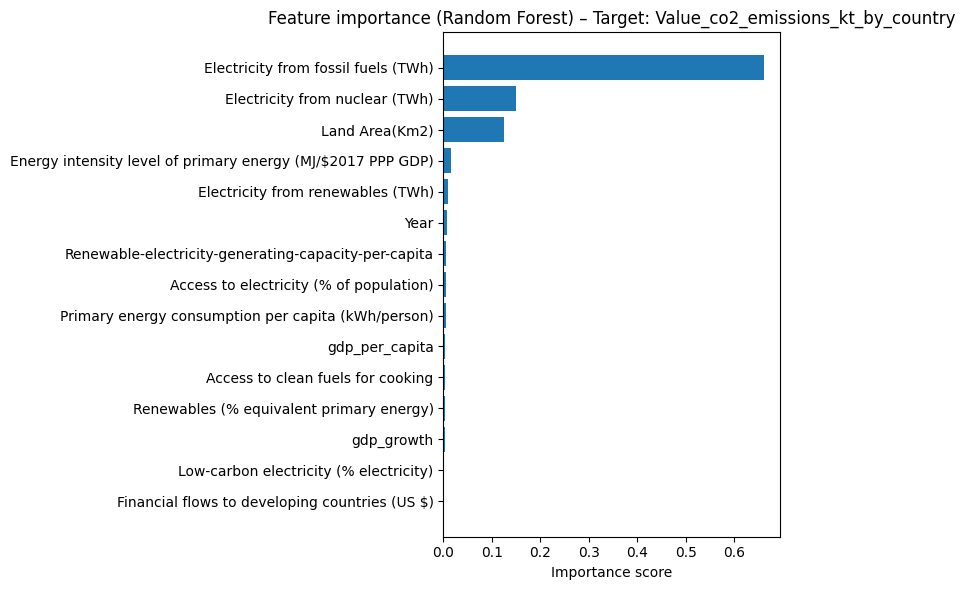


Baseline modelling for target: Renewable energy share in the total final energy consumption (%)

Linear Regression
 MAE  : 4.52
 RMSE : 5.39
 R²   : 0.904

Random Forest
 MAE  : 0.99
 RMSE : 1.66
 R²   : 0.991

RandomForest mean R² (CV=5) : 0.270


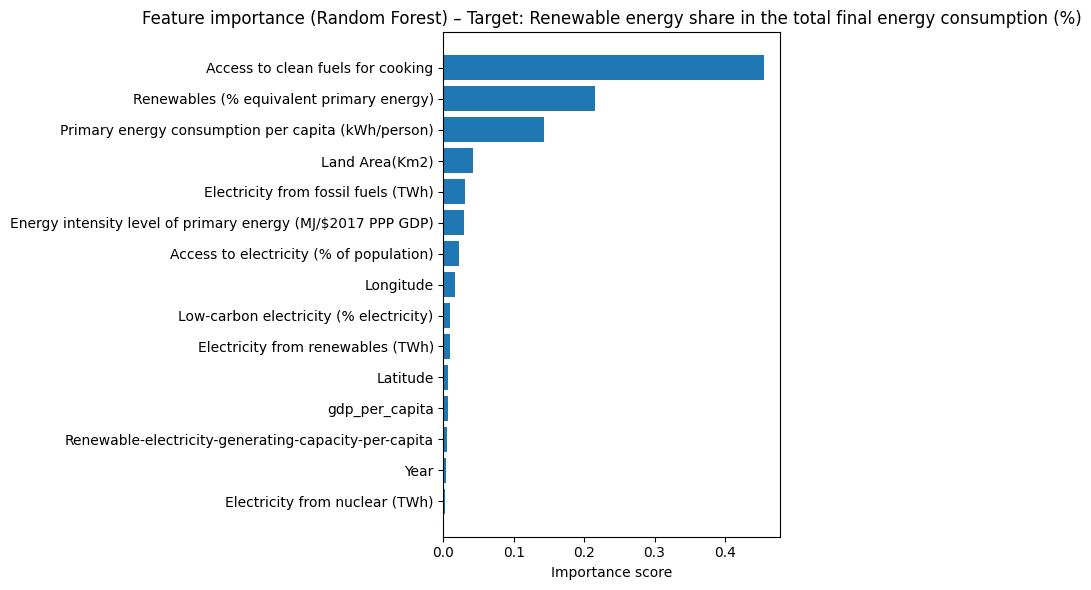

In [22]:
# ============================
# F4. Baseline models for the 2 targets
# ============================

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ici on suppose que F1 a déjà défini :
# - features : liste des colonnes explicatives
# - targets  : ['Value_co2_emissions_kt_by_country',
#               'Renewable energy share in the total final energy consumption (%)']

print("Features used:", list(features))
print("Targets:", list(targets))

for target in targets:
    print("\n" + "="*60)
    print(f"Baseline modelling for target: {target}")
    print("="*60)

    # On enlève les lignes avec NaN sur les features OU sur la target
    df_model = df.dropna(subset=features + [target])
    X_t = df_model[features]
    y_t = df_model[target]

    # Split train / test
    X_train, X_test, y_train, y_test = train_test_split(
        X_t, y_t, test_size=0.2, random_state=42
    )

    # -------------------------------
    # 1) Régression linéaire
    # -------------------------------
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred_lin = linreg.predict(X_test)

    mae_lin = mean_absolute_error(y_test, y_pred_lin)
    mse_lin = mean_squared_error(y_test, y_pred_lin)
    rmse_lin = np.sqrt(mse_lin)          # RMSE sans squared=False
    r2_lin = r2_score(y_test, y_pred_lin)

    print("\nLinear Regression")
    print(f" MAE  : {mae_lin:.2f}")
    print(f" RMSE : {rmse_lin:.2f}")
    print(f" R²   : {r2_lin:.3f}")

    # -------------------------------
    # 2) Random Forest Regressor
    # -------------------------------
    rf = RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    print("\nRandom Forest")
    print(f" MAE  : {mae_rf:.2f}")
    print(f" RMSE : {rmse_rf:.2f}")
    print(f" R²   : {r2_rf:.3f}")

    # Cross-validation R² pour la forêt aléatoire
    scores_cv = cross_val_score(
        rf, X_t, y_t, scoring='r2', cv=5, n_jobs=-1
    )
    print(f"\nRandomForest mean R² (CV=5) : {scores_cv.mean():.3f}")

    # -------------------------------
    # Importance des variables (RF)
    # -------------------------------
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    top_n = 15  # nombre de variables à afficher
    top_idx = indices[:top_n]

    plt.figure(figsize=(8, 6))
    plt.barh(
        [features[i] for i in top_idx][::-1],
        importances[top_idx][::-1]
    )
    plt.xlabel("Importance score")
    plt.title(f"Feature importance (Random Forest) – Target: {target}")
    plt.tight_layout()
    plt.show()
